# Facial recognition via deep learning

Building neural networks isn't easy. Even with popular libraries such as the [Microsoft Cognitive Toolkit](https://www.microsoft.com/en-us/cognitive-toolkit/) and [TensorFlow](https://www.tensorflow.org/) to help out, it often requires several hundred lines of code to get a neural network up and running. That's one reason [keras](https://keras.io/) has become popular in the deep-learning community. Keras is an open-source Python library that dramatically simplifies the building of neural networks. Under the hood, it uses the Microsoft Cognitive Toolkit, TensorFlow, or [Theano](https://github.com/Theano) to do the heavy lifting. With keras, you can build sophisticated neural networks with just a few lines of code and train them to classify images, analyze text for sentiment, do natural-language processing, and perform other tasks at which deep learning excels.

In this exercise, you will use keras to build a neural network that recognizes faces. You will train it with more than a thousand images from the famous "Labeled Faces in the Wild" (LFW) dataset. Along the way, you will learn the basics of building, training, and evaluating neural networks.

![](Images/lfw.png)

## Load the dataset

The first step is to import facial images from the dataset. We'll set the minimum number of faces per person to 100, which means that five sets of faces will be imported corresponding to five famous people.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

faces = fetch_lfw_people(min_faces_per_person=100)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. Each image measures 47 by 62 pixels for a total of 2,914 pixels per image. That basically means we're working with a model with 2,914 feature columns. Let's check the balance in our dataset by generating a histogram showing how many facial images were imported for each of the five personalities.

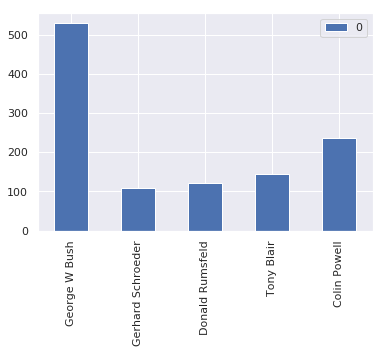

In [2]:
from collections import Counter

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

The dataset is not very well balanced, but we're not too concerned because the net effect will probably be that the model is better at recognizing certain people than others. Let's plot some of the facial images so we can see what they look like.

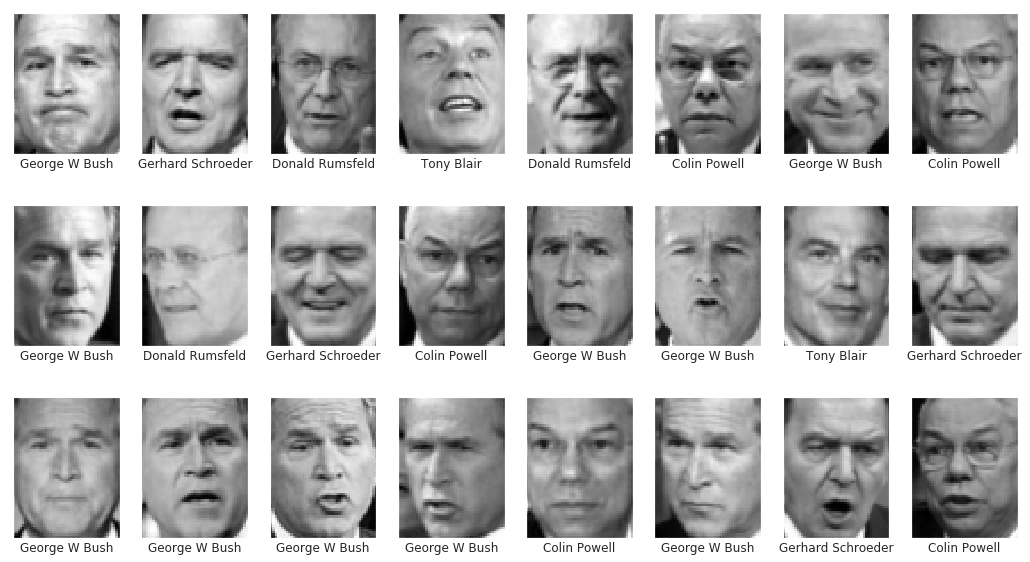

In [3]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

The next step is to convert the 42x67 images into a flat NumPy array of floats, and to convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by one-hot-encoding them. After that, we'll split the data for training and testing. Rather than allow keras to do the splitting, we'll use scikit-learn's `train_test_split` function because it gives us more control over how the split is performed.

In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = faces.images.reshape(image_count, image_width * image_height).astype('float32') / 255
face_labels = to_categorical(faces.target)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=1234)

Using TensorFlow backend.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Build and train a neural network

We'll start by using keras to build and train a neural network containing one working layer with just 16 neurons. You wouldn't expect great accuracy from such a small network, but it should train relatively quickly and give us a baseline to measure against. We'll use Stochastic Gradient Descent (SGD) as the optimization algorithm.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                46640     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 46,725
Trainable params: 46,725
Non-trainable params: 0
_________________________________________________________________


Now let's train the neural network. We'll let it run for 100 epochs and then check the result to see if it required more (or less) training. We'll also set the batch size to 8, which should provide a ressonable balance between greater accuracy (achieved with smaller batch sizes) and faster training (achieved with larger batch sizes).

In [6]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=8)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 2s 2ms/step - loss: 1.4913 - accuracy: 0.4561 - val_loss: 1.4137 - val_accuracy: 0.4386
Epoch 2/100
912/912 [==============================] - 1s 1ms/step - loss: 1.3766 - accuracy: 0.4715 - val_loss: 1.3401 - val_accuracy: 0.4386
Epoch 3/100
912/912 [==============================] - 1s 987us/step - loss: 1.3283 - accuracy: 0.4715 - val_loss: 1.3607 - val_accuracy: 0.4430
Epoch 4/100
912/912 [==============================] - 1s 946us/step - loss: 1.2918 - accuracy: 0.4846 - val_loss: 1.3677 - val_accuracy: 0.4518
Epoch 5/100
912/912 [==============================] - 1s 952us/step - loss: 1.2861 - accuracy: 0.4978 - val_loss: 1.3983 - val_accuracy: 0.4605
Epoch 6/100
912/912 [==============================] - 1s 1ms/step - loss: 1.2586 - accuracy: 0.5132 - val_loss: 1.1989 - val_accuracy: 0.5000
Epoch 7/100
912/912 [==============================] - 1s 890us/step - loss: 1.2011 - accu

912/912 [==============================] - 1s 1ms/step - loss: 0.5215 - accuracy: 0.7993 - val_loss: 0.6264 - val_accuracy: 0.7763
Epoch 58/100
912/912 [==============================] - 1s 1ms/step - loss: 0.5851 - accuracy: 0.7708 - val_loss: 0.7210 - val_accuracy: 0.7237
Epoch 59/100
912/912 [==============================] - 1s 1ms/step - loss: 0.4976 - accuracy: 0.7993 - val_loss: 0.6552 - val_accuracy: 0.7588
Epoch 60/100
912/912 [==============================] - 1s 1ms/step - loss: 0.4553 - accuracy: 0.8180 - val_loss: 0.6236 - val_accuracy: 0.7807
Epoch 61/100
912/912 [==============================] - 1s 1ms/step - loss: 0.4602 - accuracy: 0.8158 - val_loss: 0.7501 - val_accuracy: 0.7500
Epoch 62/100
912/912 [==============================] - 1s 1ms/step - loss: 0.4798 - accuracy: 0.8048 - val_loss: 0.6120 - val_accuracy: 0.7939
Epoch 63/100
912/912 [==============================] - 1s 1ms/step - loss: 0.5081 - accuracy: 0.8125 - val_loss: 0.6346 - val_accuracy: 0.7807
Epoch

keras's `fit` function returns a `history` object containing information about the training and validation accuracies measured following each epoch of the training. Let's use that information to plot the training and validation accuracy over time.

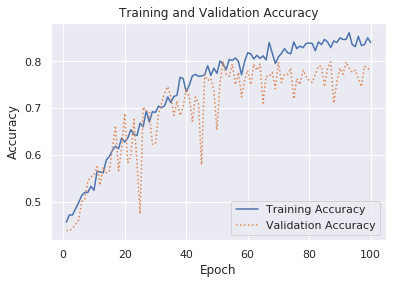

In [7]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

Everyone will get different results due to the random weights assigned to the neurons at the outset of training, but you will probably find that the training accuracy peaked out somewhere between 60% and 70%. Would we achieve better accuracy two layers of 16 neurons each rather than one? There's an easy way to find out.

In [8]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=8)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 2s 2ms/step - loss: 1.4414 - accuracy: 0.4496 - val_loss: 1.4047 - val_accuracy: 0.4737
Epoch 2/100
912/912 [==============================] - 1s 1ms/step - loss: 1.3871 - accuracy: 0.4792 - val_loss: 1.3470 - val_accuracy: 0.5044
Epoch 3/100
912/912 [==============================] - 1s 1ms/step - loss: 1.3318 - accuracy: 0.5132 - val_loss: 1.3020 - val_accuracy: 0.4868
Epoch 4/100
912/912 [==============================] - 1s 1ms/step - loss: 1.2832 - accuracy: 0.5110 - val_loss: 1.2544 - val_accuracy: 0.5439
Epoch 5/100
912/912 [==============================] - 1s 1ms/step - loss: 1.2722 - accuracy: 0.5296 - val_loss: 1.1878 - val_accuracy: 0.5570
Epoch 6/100
912/912 [==============================] - 1s 1ms/step - loss: 1.2198 - accuracy: 0.5406 - val_loss: 1.1462 - val_accuracy: 0.5570
Epoch 7/100
912/912 [==============================] - 1s 1ms/step - loss: 1.1615 - accuracy: 0.

912/912 [==============================] - 1s 1ms/step - loss: 0.3458 - accuracy: 0.8936 - val_loss: 0.5836 - val_accuracy: 0.7939
Epoch 58/100
912/912 [==============================] - 1s 1ms/step - loss: 0.3523 - accuracy: 0.8805 - val_loss: 0.7406 - val_accuracy: 0.7412
Epoch 59/100
912/912 [==============================] - 1s 1ms/step - loss: 0.3818 - accuracy: 0.8662 - val_loss: 0.6718 - val_accuracy: 0.8158
Epoch 60/100
912/912 [==============================] - 1s 1ms/step - loss: 0.2883 - accuracy: 0.9024 - val_loss: 0.5833 - val_accuracy: 0.8421
Epoch 61/100
912/912 [==============================] - 1s 1ms/step - loss: 0.4018 - accuracy: 0.8618 - val_loss: 1.3173 - val_accuracy: 0.5789
Epoch 62/100
912/912 [==============================] - 1s 1ms/step - loss: 0.3258 - accuracy: 0.8871 - val_loss: 0.7600 - val_accuracy: 0.7325
Epoch 63/100
912/912 [==============================] - 1s 1ms/step - loss: 0.3077 - accuracy: 0.8904 - val_loss: 1.0426 - val_accuracy: 0.7412
Epoch

Now let's plot the training and validation accuracy.

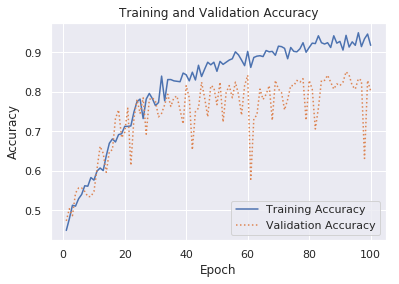

In [9]:
show_history(hist)

That's better, but could we get even better results with one layer of 128 neurons? Let's restructure the network and find out.

In [10]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=8)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 2s 3ms/step - loss: 1.4608 - accuracy: 0.4452 - val_loss: 1.3384 - val_accuracy: 0.4474
Epoch 2/100
912/912 [==============================] - 2s 2ms/step - loss: 1.3480 - accuracy: 0.5000 - val_loss: 1.3407 - val_accuracy: 0.5746
Epoch 3/100
912/912 [==============================] - 2s 2ms/step - loss: 1.2568 - accuracy: 0.5219 - val_loss: 1.2417 - val_accuracy: 0.4781
Epoch 4/100
912/912 [==============================] - 2s 2ms/step - loss: 1.1798 - accuracy: 0.5395 - val_loss: 1.0953 - val_accuracy: 0.6053
Epoch 5/100
912/912 [==============================] - 2s 2ms/step - loss: 1.1372 - accuracy: 0.5537 - val_loss: 1.1031 - val_accuracy: 0.5526
Epoch 6/100
912/912 [==============================] - 2s 2ms/step - loss: 1.0467 - accuracy: 0.5877 - val_loss: 1.0050 - val_accuracy: 0.6272
Epoch 7/100
912/912 [==============================] - 2s 2ms/step - loss: 0.9788 - accuracy: 0.

912/912 [==============================] - 2s 2ms/step - loss: 0.2616 - accuracy: 0.9112 - val_loss: 0.5691 - val_accuracy: 0.8246
Epoch 58/100
912/912 [==============================] - 2s 2ms/step - loss: 0.2892 - accuracy: 0.9090 - val_loss: 0.6002 - val_accuracy: 0.8158
Epoch 59/100
912/912 [==============================] - 2s 2ms/step - loss: 0.2054 - accuracy: 0.9364 - val_loss: 0.6236 - val_accuracy: 0.8026
Epoch 60/100
912/912 [==============================] - 2s 2ms/step - loss: 0.2482 - accuracy: 0.9112 - val_loss: 0.5296 - val_accuracy: 0.8333
Epoch 61/100
912/912 [==============================] - 2s 2ms/step - loss: 0.2280 - accuracy: 0.9254 - val_loss: 0.6806 - val_accuracy: 0.8026
Epoch 62/100
912/912 [==============================] - 2s 2ms/step - loss: 0.2039 - accuracy: 0.9408 - val_loss: 0.5498 - val_accuracy: 0.8509
Epoch 63/100
912/912 [==============================] - 2s 2ms/step - loss: 0.1944 - accuracy: 0.9331 - val_loss: 0.5193 - val_accuracy: 0.8333
Epoch

And now let's check the results.

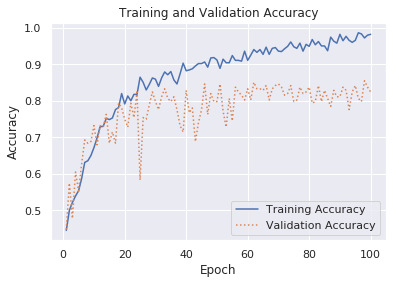

In [11]:
show_history(hist)

The fact that training accuracy approaches 100% (1.0) tells us that the network is deep enough and wide enough to learn from the facial data we train it with. But the validation accuracy peaks out much lower, typically around 85%. This means that the model isn't *generalizing* well — that is, it isn't responding as well as we would like to facial images it hasn't seen. One way to mitigate that is to introduce *dropout* during training.

## Use dropout to increase generalization

Dropout is a commonly used technique to help neural networks generalize better. "Generalize better" means responds more favorably — that is, more accurately — when presented with data it hasn't seen before. In keras, you can introduce dropout by following a `Dense` layer with a `Dropout` layer, specifying the fraction of connections that should be randomly dropped between layers in each training epoch. Let's introduce dropout to the network and see if it has an effect on the network's validation accuracy. Because dropout causes the model to train more slowly, we'll increase the number of epochs from 100 to 200.

In [12]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=8)

Train on 912 samples, validate on 228 samples
Epoch 1/200
912/912 [==============================] - 3s 3ms/step - loss: 1.4829 - accuracy: 0.4430 - val_loss: 1.4191 - val_accuracy: 0.4386
Epoch 2/200
912/912 [==============================] - 2s 2ms/step - loss: 1.3827 - accuracy: 0.4857 - val_loss: 1.3077 - val_accuracy: 0.4825
Epoch 3/200
912/912 [==============================] - 2s 2ms/step - loss: 1.3243 - accuracy: 0.4934 - val_loss: 1.2679 - val_accuracy: 0.5439
Epoch 4/200
912/912 [==============================] - 2s 2ms/step - loss: 1.2698 - accuracy: 0.5088 - val_loss: 1.4098 - val_accuracy: 0.4386
Epoch 5/200
912/912 [==============================] - 2s 2ms/step - loss: 1.2076 - accuracy: 0.5241 - val_loss: 1.1864 - val_accuracy: 0.5570
Epoch 6/200
912/912 [==============================] - 2s 2ms/step - loss: 1.1678 - accuracy: 0.5625 - val_loss: 1.2175 - val_accuracy: 0.5614
Epoch 7/200
912/912 [==============================] - 2s 2ms/step - loss: 1.1246 - accuracy: 0.

912/912 [==============================] - 2s 2ms/step - loss: 0.3405 - accuracy: 0.8849 - val_loss: 0.5059 - val_accuracy: 0.8202
Epoch 58/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3360 - accuracy: 0.8761 - val_loss: 0.4846 - val_accuracy: 0.8465
Epoch 59/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3325 - accuracy: 0.8805 - val_loss: 0.5078 - val_accuracy: 0.8158
Epoch 60/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3322 - accuracy: 0.8849 - val_loss: 0.6605 - val_accuracy: 0.7456
Epoch 61/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3303 - accuracy: 0.8794 - val_loss: 0.7298 - val_accuracy: 0.7412
Epoch 62/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3027 - accuracy: 0.8947 - val_loss: 0.4936 - val_accuracy: 0.8158
Epoch 63/200
912/912 [==============================] - 2s 2ms/step - loss: 0.3104 - accuracy: 0.8925 - val_loss: 0.4794 - val_accuracy: 0.8421
Epoch

Epoch 114/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1567 - accuracy: 0.9452 - val_loss: 0.5838 - val_accuracy: 0.8158
Epoch 115/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1318 - accuracy: 0.9616 - val_loss: 0.5403 - val_accuracy: 0.8684
Epoch 116/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1344 - accuracy: 0.9561 - val_loss: 0.5271 - val_accuracy: 0.8377
Epoch 117/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1633 - accuracy: 0.9375 - val_loss: 0.5423 - val_accuracy: 0.8333
Epoch 118/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1396 - accuracy: 0.9583 - val_loss: 0.5397 - val_accuracy: 0.8289
Epoch 119/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1449 - accuracy: 0.9463 - val_loss: 0.5187 - val_accuracy: 0.8509
Epoch 120/200
912/912 [==============================] - 2s 3ms/step - loss: 0.1278 - accuracy: 0.9518 - val_loss: 0.5391 - val_ac

912/912 [==============================] - 2s 2ms/step - loss: 0.1183 - accuracy: 0.9660 - val_loss: 0.5915 - val_accuracy: 0.8333
Epoch 171/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1337 - accuracy: 0.9529 - val_loss: 0.6317 - val_accuracy: 0.8202
Epoch 172/200
912/912 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9682 - val_loss: 0.5485 - val_accuracy: 0.8465
Epoch 173/200
912/912 [==============================] - 2s 2ms/step - loss: 0.0806 - accuracy: 0.9770 - val_loss: 0.5664 - val_accuracy: 0.8465
Epoch 174/200
912/912 [==============================] - 2s 2ms/step - loss: 0.0984 - accuracy: 0.9627 - val_loss: 0.6369 - val_accuracy: 0.8465
Epoch 175/200
912/912 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9649 - val_loss: 0.5714 - val_accuracy: 0.8246
Epoch 176/200
912/912 [==============================] - 2s 2ms/step - loss: 0.0734 - accuracy: 0.9781 - val_loss: 0.5954 - val_accuracy: 0.8465

Now let's plot the training history as usual. Does the model seem to generalize better?

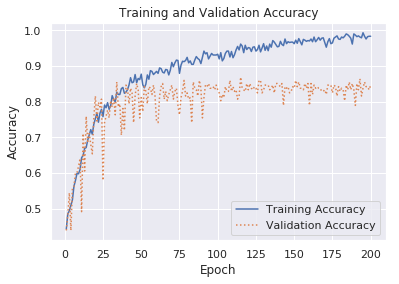

In [13]:
show_history(hist)

Most likely, the gap between training accuracy and validation accuracy diminished, which means that the model does seem to generalize better. But the gap didn't diminish enough. Let's try increasing the droput from 20% to 50% and see if that closes the gap further. Since dropout causes a network to train more slowly (that is, it does less learning in each epoch), we will also increase the number of epochs to 500. Note that this final training run could take 20 minutes or more to complete.

In [14]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, batch_size=8)

Train on 912 samples, validate on 228 samples
Epoch 1/500
912/912 [==============================] - 3s 3ms/step - loss: 1.5096 - accuracy: 0.4298 - val_loss: 1.4347 - val_accuracy: 0.4386
Epoch 2/500
912/912 [==============================] - 2s 2ms/step - loss: 1.4537 - accuracy: 0.4638 - val_loss: 1.4332 - val_accuracy: 0.4386
Epoch 3/500
912/912 [==============================] - 2s 2ms/step - loss: 1.4339 - accuracy: 0.4671 - val_loss: 1.3996 - val_accuracy: 0.4386
Epoch 4/500
912/912 [==============================] - 2s 2ms/step - loss: 1.3920 - accuracy: 0.4770 - val_loss: 1.3687 - val_accuracy: 0.4386
Epoch 5/500
912/912 [==============================] - 2s 2ms/step - loss: 1.3850 - accuracy: 0.4682 - val_loss: 1.3394 - val_accuracy: 0.4386
Epoch 6/500
912/912 [==============================] - 2s 2ms/step - loss: 1.3426 - accuracy: 0.4803 - val_loss: 1.3167 - val_accuracy: 0.4386
Epoch 7/500
912/912 [==============================] - 2s 2ms/step - loss: 1.3289 - accuracy: 0.

912/912 [==============================] - 2s 2ms/step - loss: 0.7703 - accuracy: 0.6919 - val_loss: 0.6512 - val_accuracy: 0.7675
Epoch 58/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7397 - accuracy: 0.7116 - val_loss: 0.6799 - val_accuracy: 0.7763
Epoch 59/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7224 - accuracy: 0.7270 - val_loss: 0.6735 - val_accuracy: 0.7412
Epoch 60/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7566 - accuracy: 0.6974 - val_loss: 0.6660 - val_accuracy: 0.7412
Epoch 61/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7492 - accuracy: 0.7061 - val_loss: 0.6287 - val_accuracy: 0.7763
Epoch 62/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7190 - accuracy: 0.7259 - val_loss: 0.6714 - val_accuracy: 0.7939
Epoch 63/500
912/912 [==============================] - 2s 2ms/step - loss: 0.7128 - accuracy: 0.7171 - val_loss: 0.6625 - val_accuracy: 0.7851
Epoch

Epoch 114/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5492 - accuracy: 0.7851 - val_loss: 0.5276 - val_accuracy: 0.8114
Epoch 115/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5273 - accuracy: 0.7840 - val_loss: 0.5770 - val_accuracy: 0.8114
Epoch 116/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5306 - accuracy: 0.7917 - val_loss: 0.4623 - val_accuracy: 0.8640
Epoch 117/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4989 - accuracy: 0.8103 - val_loss: 0.4842 - val_accuracy: 0.8421
Epoch 118/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5169 - accuracy: 0.7895 - val_loss: 0.5948 - val_accuracy: 0.8070
Epoch 119/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5289 - accuracy: 0.8015 - val_loss: 0.4921 - val_accuracy: 0.8421
Epoch 120/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5028 - accuracy: 0.7971 - val_loss: 0.5083 - val_ac

912/912 [==============================] - 2s 2ms/step - loss: 0.4363 - accuracy: 0.8366 - val_loss: 0.5484 - val_accuracy: 0.8289
Epoch 171/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4673 - accuracy: 0.8300 - val_loss: 0.5833 - val_accuracy: 0.7851
Epoch 172/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4779 - accuracy: 0.8004 - val_loss: 0.5408 - val_accuracy: 0.8114
Epoch 173/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5051 - accuracy: 0.7862 - val_loss: 0.7772 - val_accuracy: 0.7061
Epoch 174/500
912/912 [==============================] - 2s 2ms/step - loss: 0.5049 - accuracy: 0.7884 - val_loss: 0.5177 - val_accuracy: 0.8070
Epoch 175/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4524 - accuracy: 0.8158 - val_loss: 0.5395 - val_accuracy: 0.8114
Epoch 176/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4358 - accuracy: 0.8224 - val_loss: 0.5151 - val_accuracy: 0.8377

912/912 [==============================] - 2s 2ms/step - loss: 0.4007 - accuracy: 0.8202 - val_loss: 0.5611 - val_accuracy: 0.8465
Epoch 227/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3793 - accuracy: 0.8443 - val_loss: 0.6129 - val_accuracy: 0.8333
Epoch 228/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3836 - accuracy: 0.8498 - val_loss: 0.5660 - val_accuracy: 0.8070
Epoch 229/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4383 - accuracy: 0.8213 - val_loss: 0.5009 - val_accuracy: 0.8202
Epoch 230/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4161 - accuracy: 0.8289 - val_loss: 0.5808 - val_accuracy: 0.8465
Epoch 231/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4520 - accuracy: 0.8235 - val_loss: 0.6327 - val_accuracy: 0.7982
Epoch 232/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4006 - accuracy: 0.8410 - val_loss: 0.4823 - val_accuracy: 0.8553

912/912 [==============================] - 2s 2ms/step - loss: 0.3787 - accuracy: 0.8465 - val_loss: 0.4954 - val_accuracy: 0.8640
Epoch 283/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3853 - accuracy: 0.8432 - val_loss: 0.6088 - val_accuracy: 0.8070
Epoch 284/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3581 - accuracy: 0.8498 - val_loss: 0.5602 - val_accuracy: 0.8377
Epoch 285/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4151 - accuracy: 0.8289 - val_loss: 0.5304 - val_accuracy: 0.8202
Epoch 286/500
912/912 [==============================] - 2s 2ms/step - loss: 0.4215 - accuracy: 0.8169 - val_loss: 0.6517 - val_accuracy: 0.8465
Epoch 287/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3807 - accuracy: 0.8388 - val_loss: 0.5262 - val_accuracy: 0.8465
Epoch 288/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3491 - accuracy: 0.8476 - val_loss: 0.5522 - val_accuracy: 0.8158

912/912 [==============================] - 2s 3ms/step - loss: 0.3105 - accuracy: 0.8728 - val_loss: 0.5814 - val_accuracy: 0.8421
Epoch 339/500
912/912 [==============================] - 2s 3ms/step - loss: 0.3499 - accuracy: 0.8607 - val_loss: 0.5970 - val_accuracy: 0.8333
Epoch 340/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3050 - accuracy: 0.8772 - val_loss: 0.6032 - val_accuracy: 0.8421
Epoch 341/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2823 - accuracy: 0.8893 - val_loss: 0.5809 - val_accuracy: 0.8509
Epoch 342/500
912/912 [==============================] - 2s 3ms/step - loss: 0.3433 - accuracy: 0.8651 - val_loss: 0.7123 - val_accuracy: 0.8026
Epoch 343/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3276 - accuracy: 0.8596 - val_loss: 0.6897 - val_accuracy: 0.8421
Epoch 344/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3170 - accuracy: 0.8640 - val_loss: 0.6497 - val_accuracy: 0.8640

912/912 [==============================] - 2s 2ms/step - loss: 0.2376 - accuracy: 0.9035 - val_loss: 0.7041 - val_accuracy: 0.8421
Epoch 395/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2937 - accuracy: 0.8794 - val_loss: 0.6315 - val_accuracy: 0.8202
Epoch 396/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2917 - accuracy: 0.8794 - val_loss: 0.6603 - val_accuracy: 0.8421
Epoch 397/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2976 - accuracy: 0.8772 - val_loss: 0.6983 - val_accuracy: 0.8246
Epoch 398/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3006 - accuracy: 0.8805 - val_loss: 0.7633 - val_accuracy: 0.8158
Epoch 399/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3117 - accuracy: 0.8739 - val_loss: 0.8614 - val_accuracy: 0.8202
Epoch 400/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3110 - accuracy: 0.8838 - val_loss: 0.5541 - val_accuracy: 0.8465

912/912 [==============================] - 2s 2ms/step - loss: 0.3063 - accuracy: 0.8717 - val_loss: 0.6649 - val_accuracy: 0.8465
Epoch 451/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2972 - accuracy: 0.8706 - val_loss: 0.6796 - val_accuracy: 0.8246
Epoch 452/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2704 - accuracy: 0.8914 - val_loss: 0.7052 - val_accuracy: 0.8377
Epoch 453/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2381 - accuracy: 0.9101 - val_loss: 0.6930 - val_accuracy: 0.8289
Epoch 454/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2709 - accuracy: 0.8958 - val_loss: 0.6292 - val_accuracy: 0.8465
Epoch 455/500
912/912 [==============================] - 2s 2ms/step - loss: 0.3242 - accuracy: 0.8772 - val_loss: 0.6134 - val_accuracy: 0.8377
Epoch 456/500
912/912 [==============================] - 2s 2ms/step - loss: 0.2800 - accuracy: 0.8838 - val_loss: 0.7411 - val_accuracy: 0.8377

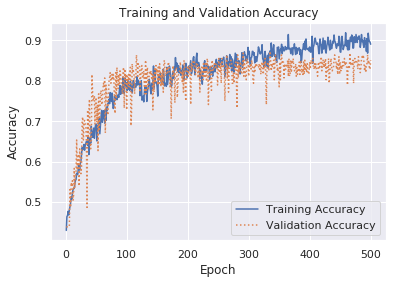

In [15]:
show_history(hist)

How do the results compare to the previous run with a 20% dropout rate? The gap probably closed some more, but it also may be apparent that even 500 epochs weren't enough. (What is the maximum training accuracy achieved?) Time permitting, it might be worthwhile to try 1,000 epochs. However, we'll leave that as a homework exercise given that training is starting to take a long time.

## Plot a confusion matrix

It might be helpful to run the test data through the network and generate a confusion matrix showing how it performed. We can use scikit-learn's `confusion_matrix` function to generate the confusion matrix and seaborn to plot it.

Text(89.18, 0.5, 'Predicted label')

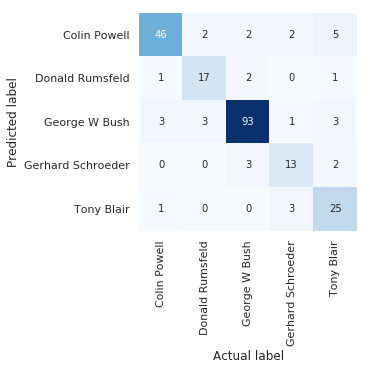

In [16]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

How many times out of 51 did the model correctly identify Colin Powell? In 100 attempts, how many times did it accurately identify George W. Bush? How does its accuracy compare to the SVM facial-recognition model that you built earlier?